## Outperform the baseline by adding more sophisiticated features

**With more granularity time steps and 3 new time-domain signals, this fine-tuned CNN has an overall F1 score of 85.2%, which 17.9% outperforms the baseline (67.3%).**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from numpy.lib.stride_tricks import as_strided

import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPooling1D
from keras.utils import np_utils

from sklearn.metrics import confusion_matrix

### Load aggregated accelerometer data

In [2]:
driving_df = pd.read_csv('sophisticated_acc_signals.csv')

driving_df['timestamp'] = pd.to_datetime(driving_df['timestamp'])

driving_df.shape

(165875, 11)

In [3]:
driving_df.head()

,time_step,device_id,trip_id,timestamp,speed,acc_x,acc_y,acc_z,freq_acc_x,freq_acc_y,freq_acc_z
0,26,1,1,2018-01-24 19:48:27,3,-0.132093,0.112316,-0.908787,3.038785,1.964435,0.991609
1,26,1,1,2018-01-24 19:48:27,3,-0.197609,0.031063,-1.021868,2.306789,2.774992,3.911140
2,26,1,1,2018-01-24 19:48:27,3,-0.093705,0.087727,-0.975970,2.255192,1.278453,0.488883
3,26,1,1,2018-01-24 19:48:27,3,-0.051409,0.082636,-1.033521,2.465784,1.973234,3.325745
4,26,1,1,2018-01-24 19:48:27,3,-0.111199,0.054486,-1.028309,3.174646,0.493061,2.070297


### Driving history 
By looking at the driving days of each device, we can see some of the days are close.

In [4]:
def device_driving_history(df):

    df['day_of_the_month'] = df['timestamp'].dt.day.astype(str)

    return df[['device_id', 'day_of_the_month']]\
        .drop_duplicates()\
        .groupby(['device_id'])\
        .agg({'day_of_the_month': lambda x: ', '.join(x.values)})

device_driving_history(driving_df.copy())

,day_of_the_month
device_id,
1,"24, 25"
3,"11, 21, 28, 31"
5,"10, 12, 19, 22"
6,31
7,"12, 18"
10,"1, 3, 9, 13, 19, 20, 28, 29, 30"
11,31


In [5]:
# driving_df = driving_df[~driving_df['device_id'].isin([6, 7, 1])] 

### Transform signals into window samples

We can apply a rolling window to the time steps for each trip. A window is a period of timestamps, or a list of row index in code. This helps us to easily extract samples for each window from the full driving history.

In [6]:
driving_df.head()

,time_step,device_id,trip_id,timestamp,speed,acc_x,acc_y,acc_z,freq_acc_x,freq_acc_y,freq_acc_z
0,26,1,1,2018-01-24 19:48:27,3,-0.132093,0.112316,-0.908787,3.038785,1.964435,0.991609
1,26,1,1,2018-01-24 19:48:27,3,-0.197609,0.031063,-1.021868,2.306789,2.774992,3.911140
2,26,1,1,2018-01-24 19:48:27,3,-0.093705,0.087727,-0.975970,2.255192,1.278453,0.488883
3,26,1,1,2018-01-24 19:48:27,3,-0.051409,0.082636,-1.033521,2.465784,1.973234,3.325745
4,26,1,1,2018-01-24 19:48:27,3,-0.111199,0.054486,-1.028309,3.174646,0.493061,2.070297


In [7]:
driving_df[['device_id', 'trip_id', 'time_step']]

,device_id,trip_id,time_step
0,1,1,26
1,1,1,26
2,1,1,26
3,1,1,26
4,1,1,26
...,...,...,...
165870,11,9,567
165871,11,9,567
165872,11,9,567
165873,11,9,567


In [8]:
def windowed_view(arr, window, overlap):
    """ Apply rolling windows into the given array with an overlap
    """
    
    arr = np.asarray(arr)
    window_step = window - overlap
    new_shape = arr.shape[:-1] + ((arr.shape[-1] - overlap) // window_step, window)
    new_strides = (arr.strides[:-1] + (window_step * arr.strides[-1],) + arr.strides[-1:])
    
    return as_strided(arr, shape=new_shape, strides=new_strides)

In [9]:
def create_window_samples(df, window, overlap):
    """ Save all the row index of the rolling windows.
    """
    
    window_index_list = list()
    labels_list = list()
    
    for (device_id, trip_id), trip_df in df.groupby(['device_id', 'trip_id']):
#         print(trip_df)
        trip_length = trip_df.shape[0]
        window_index = windowed_view(trip_df.index, window, overlap)
        labels = np.full((window_index.shape[0], 1), device_id)
        window_index_list.append(window_index)
        labels_list.append(labels)

    return np.concatenate(window_index_list), np.concatenate(labels_list)

In [10]:
window_samples, labels = create_window_samples(driving_df, window=50*25, overlap=25*25)

In [11]:
window_samples

array([[   825,    826,    827, ...,   2072,   2073,   2074],
       [  1450,   1451,   1452, ...,   2697,   2698,   2699],
       [  2075,   2076,   2077, ...,   3322,   3323,   3324],
       ...,
       [162950, 162951, 162952, ..., 164197, 164198, 164199],
       [163575, 163576, 163577, ..., 164822, 164823, 164824],
       [164200, 164201, 164202, ..., 165447, 165448, 165449]])

In [12]:
def extract_signals_per_window(df, window_samples, labels):
    """ Since the given window samples are a list of windows with row index. 
    We now need to use the index to extract signals from the driving history data.
    """
    
    signal_window_samples_list = list()
    
    for window, device_id in zip(window_samples, labels):
        
        # Standardize the speed and accelerometer signals
#         transformed_signals = StandardScaler().fit_transform(df.loc[window][['acc_x', 'acc_y', 'acc_z']])
        transformed_signals = df.loc[window][['acc_x', 'acc_y', 'acc_z', 'freq_acc_x', 'freq_acc_y', 'freq_acc_z',]]
        signal_window_samples_list.append(transformed_signals)
    
    return np.asarray(signal_window_samples_list)

In [13]:
signal_window_samples = extract_signals_per_window(driving_df, window_samples, labels)

In [14]:
signal_window_samples.shape, labels.shape

((218, 1250, 6), (218, 1))

In [15]:
pd.Series(labels.reshape(-1), name='labels').value_counts()

10    101
5      45
3      37
11     21
6       6
7       5
1       3
Name: labels, dtype: int64

In [16]:
X = signal_window_samples.copy()
y = labels.copy()

device_to_label = {category: i for i, category in enumerate(set(y.reshape(-1)))}
label_to_device = {i: category for i, category in enumerate(set(y.reshape(-1)))}
device_to_label

for device_id, label in device_to_label.items():
    y[y == device_id] = label

# Since the window samples are small, we should stratify on the device ids.
# This can make sure we have both training / test samples for each device id.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.8, 
                                                    stratify=y, 
                                                    shuffle=True, 
                                                    random_state=42)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# one-hot encoding using keras' numpy-related utilities
n_classes = len(device_to_label)
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (43, 1)
Shape after one-hot encoding:  (43, 7)


In [17]:
# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv1D(filters=120, kernel_size=5, activation='tanh', input_shape=(1250, 6)))
model.add(MaxPool1D(pool_size=5))

model.add(Conv1D(filters=60, kernel_size=5, activation='tanh'))
model.add(MaxPool1D(pool_size=5))

model.add(Conv1D(filters=30, kernel_size=5, activation='tanh'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))

model.add(Dense(n_classes, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Print out CNN Architecture

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1246, 120)         3720      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 120)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 245, 60)           36060     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 49, 60)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 30)            9030      
                                                                 
 global_max_pooling1d (Globa  (None, 30)               0

### CNN Training logs

In [19]:
 model.fit(X_train, Y_train, batch_size=1, epochs=60, validation_data=(X_test, Y_test))

Epoch 1/60


2022-04-13 00:01:47.511054: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


43/43 [==============================] - 1s 7ms/step - loss: 1.8117 - accuracy: 0.3721 - val_loss: 1.4500 - val_accuracy: 0.5200
Epoch 2/60
43/43 [==============================] - 0s 5ms/step - loss: 1.6942 - accuracy: 0.4651 - val_loss: 1.2496 - val_accuracy: 0.4914
Epoch 3/60
43/43 [==============================] - 0s 6ms/step - loss: 1.7193 - accuracy: 0.5116 - val_loss: 1.2876 - val_accuracy: 0.4800
Epoch 4/60
43/43 [==============================] - 0s 6ms/step - loss: 1.7092 - accuracy: 0.5116 - val_loss: 1.1912 - val_accuracy: 0.5429
Epoch 5/60
43/43 [==============================] - 0s 6ms/step - loss: 1.3282 - accuracy: 0.5814 - val_loss: 1.4165 - val_accuracy: 0.2971
Epoch 6/60
43/43 [==============================] - 0s 6ms/step - loss: 1.2453 - accuracy: 0.5814 - val_loss: 0.7604 - val_accuracy: 0.7771
Epoch 7/60
43/43 [==============================] - 0s 6ms/step - loss: 0.9986 - accuracy: 0.7442 - val_loss: 0.7229 - val_accuracy: 0.8400
Epoch 8/60
43/43 [=============

43/43 [==============================] - 0s 6ms/step - loss: 0.1866 - accuracy: 0.9767 - val_loss: 0.0760 - val_accuracy: 0.9886
Epoch 60/60
43/43 [==============================] - 0s 6ms/step - loss: 0.1454 - accuracy: 0.9767 - val_loss: 0.0732 - val_accuracy: 0.9886


In [20]:
Y_pred = model.predict(X_test)

### Model evaluation

Calculate recall and precision for each device id.

In the confusion matrix, we can see precision and recall for device 1 are still both 0. **But it now can learn well for device 6 and 7 even with the same size of training samples!**

**This fine-tuned CNN has an overall F1 score of 85.2%, which 17.9% outperforms the baseline (67.3%).**

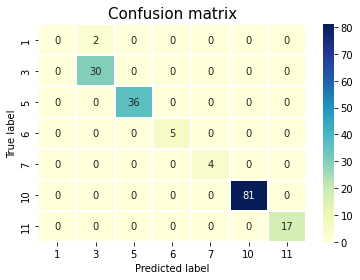

In [21]:
c_m = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

fig = plt.figure()
labels = sorted(list(set(y.reshape(-1))))
device_ids = [label_to_device[l] for l in labels]
sns.heatmap(c_m, xticklabels=device_ids, yticklabels=device_ids, annot=True, 
            linewidths = 0.1, fmt="d", cmap = "YlGnBu")
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel("True label")
plt.xlabel("Predicted label")
confusion_matrix_plot = fig

In [22]:
recall = np.diag(c_m) / np.sum(c_m, axis = 1)
precision = np.diag(c_m) / np.sum(c_m, axis = 0)
f1 = 2 * precision * recall / (precision + recall)

evaluation_df = pd.DataFrame({
    'device_id': device_ids,
    'recall': recall,
    'precision': precision,
    'f1': f1
}).set_index('device_id')

evaluation_df.fillna(0)

/var/folders/wj/kg65sk251rz1g4h8_694mm9r0000gn/T/ipykernel_52266/1451942175.py:2: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diag(c_m) / np.sum(c_m, axis = 0)


,recall,precision,f1
device_id,,,
1,0.0,0.0000,0.000000
3,1.0,0.9375,0.967742
5,1.0,1.0000,1.000000
6,1.0,1.0000,1.000000
7,1.0,1.0000,1.000000
10,1.0,1.0000,1.000000
11,1.0,1.0000,1.000000


In [23]:
print("Overall f1 score: {:,.3f}%".format(evaluation_df['f1'].fillna(0).mean()*100))

Overall f1 score: 85.253%
